In [1]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import xml.etree.ElementTree as etree
import os
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def parse_annot(annot_file_path):
    # returns the bounding box coords and class agonistic centers for each object in annot file
    results = {}
    #centers = []
    xml_file = etree.parse(annot_file_path)
    root = xml_file.getroot()
    #img_height = xml_file.findtext('.//height')
    #img_width = xml_file.findtext('.//width') 
    for obj in root.iter('object'):
        cls = obj.find('name').text
        if cls not in results.keys():
            results[cls] = []
        xmin = int(round(float(obj.find('bndbox').find('xmin').text)))
        ymin = int(round(float(obj.find('bndbox').find('ymin').text)))
        xmax = int(round(float(obj.find('bndbox').find('xmax').text)))
        ymax = int(round(float(obj.find('bndbox').find('ymax').text)))
        coords = [xmin, ymin, xmax, ymax]
        #center = get_center(coords)
        #centers.append(center)
        results[cls].append(coords)
    return results#, centers

In [3]:
def get_center(coords):
    
    x = (coords[0] + coords[2]) / 2.0
    y = (coords[1] + coords[3]) / 2.0
    
    return[x, y]

In [4]:
def get_grid_info(img_size, grid_size):
    coords = []
    centers = []
    # assuming grid and img size are symmetric
    each_grid = img_size[0] / grid_size[0]
    xmin, ymin = (0, 0)
    xmax, ymax = int(each_grid), int(each_grid)
    for each_grid in range(grid_size[0] * grid_size[1]):
        width = xmax - xmin
        height  = ymax - ymin
        bbox = [xmin, ymin, xmax, ymax]
        centers.append(get_center(bbox))
        coords.append(bbox)
        if (each_grid + 1) % grid_size[0] !=0:
            xmin = xmax
            ymin = ymin
            xmax = xmin + width
            ymax = ymin + height
        else:
            xmin = 0
            ymin = ymax 
            xmax = xmin + width
            ymax = ymin + height
    return coords, centers

In [5]:
def find_object_grid(object_centers, grid_centers):
    
    #grid_coord, grid_centers = get_grid_info(img_size=input_size, grid_size=grid_size)
    grid_centers = np.asarray(grid_centers, dtype=float)
    box_nums = []
    if len(object_centers) > 2:
        for center in object_centers:
            box_num = np.argmin(np.sqrt(np.sum(np.square(grid_centers - center), axis=1)))
            box_nums.append(box_num)
    else:
            box_num = np.argmin(np.sqrt(np.sum(np.square(grid_centers - object_centers), axis=1)))
            return box_num
    return box_nums

#### The flow of the parsing annotations would be as follows

   1. Parse the annotation file to get the classes with their bounding box information and centers *parse_annot()*  
   1. To find where each object falls in the grid
        1. Transform the image to fixed image size say 224x224 and then transform the bbox coords and object centers
        1. Make the grid by calling *get_grid_info()* which returns grid coordinates and grid centers
        1. Get the centers of each object after parsing the annotation file
        1. Compare the distance between the object centers and grid centers and get the args of least distance *find_object_grid()*

In [6]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize

class DataGenerator(object):

    def __init__(self, dim_x = 224, dim_y = 224, channels = 3, grid_size=(3, 3), batch_size = 32, img_path=None, shuffle = True):
        'Initialization'
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_z = channels
        self.grid_size = grid_size
        self.batch_size = batch_size
        self.img_path = img_path
        self.shuffle = shuffle

    def generate(self, labels, list_IDs):
        'Generates batches of samples'
        # Infinite loop
        while 1:
        # Generate order of exploration of dataset
            indexes = self.__get_exploration_order(list_IDs)

            # Generate batches
            imax = int(len(indexes)/self.batch_size)
            for i in range(imax):
            # Find list of IDs
                list_IDs_temp = [list_IDs[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]

                # Generate data
                X, y = self.__data_generation(labels, list_IDs_temp)

                yield X, y

    def __get_exploration_order(self, list_IDs):
        'Generates order of exploration'
        # Find exploration order
        indexes = np.arange(len(list_IDs))
        if self.shuffle == True:
            np.random.shuffle(indexes)
        return indexes

    def __data_generation(self, labels, list_IDs_temp):
        'Generates data of batch_size samples' # X : (n_samples, v_size, v_size, v_size, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim_x, self.dim_y, self.dim_z))
        #y = np.empty((self.batch_size, 4), dtype = int)
        new_y = np.zeros(shape=(self.batch_size, self.grid_size[0], self.grid_size[1], 5), dtype=float)
        
        grid_coords, grid_centers = get_grid_info(img_size=(self.dim_x, self.dim_y), grid_size=(self.grid_size[0], self.grid_size[1]))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            #img = imread('./images/'+ID+'.jpg')
            img = imread(self.img_path + ID + '.jpg')
            real_h, real_w, c = img.shape
            img = resize(img, (self.dim_x, self.dim_y), mode='reflect')
            
            X[i] = img

            # Store volume
            #X[i, :, :, :, 0] = np.load(ID + '.npy')

            # Fixing the bbox after image resize
            bbox_list = labels[ID]
            for each_bbox in bbox_list:
                
                center = get_center(each_bbox)
                center_x = center[0] / real_w
                center_y = center[1] / real_h
                w_box = (each_bbox[2] - each_bbox[0]) / real_w
                h_box = (each_bbox[3] - each_bbox[1]) / real_h
                
                center_x = center_x * self.dim_x / real_w
                
                center_y = center_y * self.dim_y / real_h
                
                w_box = w_box * self.dim_x / real_w
                
                h_box = h_box * self.dim_y / real_h
                
                ## This section is to determine the grid where the object falls
                xmin = each_bbox[0] * self.dim_x / real_w
                #xmin = max(min(xmin, real_w), 0)
                xmax = each_bbox[2] * self.dim_x / real_w
                #xmax = max(min(xmax, real_w), 0)
                ymin = each_bbox[1] * self.dim_y / real_h
                #ymin = max(min(ymin, real_h), 0)
                ymax = each_bbox[3] * self.dim_y / real_h
                #ymax = max(min(ymax, real_h), 0)
                
        
                coords = (xmin, ymin, xmax, ymax)
                obj_center = get_center(coords)
                
                
                grid_arg = find_object_grid(object_centers=obj_center, grid_centers=grid_centers)
    
                
                #new_y[i, grid_arg // self.grid_size[0], grid_arg % self.grid_size[0] , : ] = [1, xmin, ymin, xmax, ymax]
            
                new_y[i, grid_arg // self.grid_size[0], grid_arg % self.grid_size[0] , : ] = [1, center_x, center_y, w_box, h_box]

        return X, new_y


In [7]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize

class DataGenerator(object):

    def __init__(self, dim_x = 224, dim_y = 224, channels = 3, grid_size=(3, 3), batch_size = 32, img_path=None, shuffle = True):
        'Initialization'
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_z = channels
        self.grid_size = grid_size
        self.batch_size = batch_size
        self.img_path = img_path
        self.shuffle = shuffle

    def generate(self, labels, list_IDs):
        'Generates batches of samples'
        # Infinite loop
        while 1:
        # Generate order of exploration of dataset
            indexes = self.__get_exploration_order(list_IDs)

            # Generate batches
            imax = int(len(indexes)/self.batch_size)
            for i in range(imax):
            # Find list of IDs
                list_IDs_temp = [list_IDs[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]

                # Generate data
                X, y = self.__data_generation(labels, list_IDs_temp)

                yield X, y

    def __get_exploration_order(self, list_IDs):
        'Generates order of exploration'
        # Find exploration order
        indexes = np.arange(len(list_IDs))
        if self.shuffle == True:
            np.random.shuffle(indexes)
        return indexes

    def __data_generation(self, labels, list_IDs_temp):
        'Generates data of batch_size samples' # X : (n_samples, v_size, v_size, v_size, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim_x, self.dim_y, self.dim_z))
        #y = np.empty((self.batch_size, 4), dtype = int)
        new_y = np.zeros(shape=(self.batch_size, self.grid_size[0], self.grid_size[1], 5))
        
        grid_coords, grid_centers = get_grid_info(img_size=(self.dim_x, self.dim_y), grid_size=(self.grid_size[0], self.grid_size[1]))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            #img = imread('./images/'+ID+'.jpg')
            img = imread(self.img_path + ID + '.jpg')
            real_h, real_w, c = img.shape
            img = resize(img, (self.dim_x, self.dim_y), mode='reflect')
            
            X[i] = img

            # Store volume
            #X[i, :, :, :, 0] = np.load(ID + '.npy')

            # Fixing the bbox after image resize
            bbox_list = labels[ID]
            for each_bbox in bbox_list:
                
                ## This section is to determine the grid where the object falls
                xmin = each_bbox[0] * self.dim_x / real_w
                #xmin = max(min(xmin, real_w), 0)
                xmax = each_bbox[2] * self.dim_x /real_w
                #xmax = max(min(xmax, real_w), 0)
                ymin = each_bbox[1] * self.dim_y / real_h
                #ymin = max(min(ymin, real_h), 0)
                ymax = each_bbox[3] * self.dim_y / real_h
                #ymax = max(min(ymax, real_h), 0)
                
        
                coords = (xmin, ymin, xmax, ymax)
                obj_center = get_center(coords)
                
                
                grid_arg = find_object_grid(object_centers=obj_center, grid_centers=grid_centers)
                
                # center of the object wrt grid cell
                # here I assume grid size to be symmetric if not then divide by respective width and height
                cx = obj_center[0] / self.dim_x / self.grid_size[0]
                cy = obj_center[1] / self.dim_y / self.grid_size[0]
                
                w = xmax - xmin / self.dim_x
                h = ymax - ymin / self.dim_y
                
                new_y[i, grid_arg // self.grid_size[0], grid_arg % self.grid_size[0] , : ] = [1, cx, cy, w, h]
                

    
                
                #new_y[i, grid_arg // self.grid_size[0], grid_arg % self.grid_size[0] , : ] = [1, xmin, ymin, xmax, ymax]
            
                #new_y[i, grid_arg // self.grid_size[0], grid_arg % self.grid_size[0] , : ] = [1, xmin/real_w, ymin/real_h, xmax/real_w, ymax/real_h]

        return X, new_y


In [8]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize

class DataGenerator(object):

    def __init__(self, dim_x = 224, dim_y = 224, channels = 3, grid_size=(3, 3), anchors=1, batch_size = 32, img_path=None, shuffle = True):
        'Initialization'
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_z = channels
        self.grid_size = grid_size
        self.batch_size = batch_size
        self.img_path = img_path
        self.shuffle = shuffle
        self.anchors = anchors

    def generate(self, labels, list_IDs):
        'Generates batches of samples'
        # Infinite loop
        while 1:
        # Generate order of exploration of dataset
            indexes = self.__get_exploration_order(list_IDs)

            # Generate batches
            imax = int(len(indexes)/self.batch_size)
            for i in range(imax):
            # Find list of IDs
                list_IDs_temp = [list_IDs[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]

                # Generate data
                X, y = self.__data_generation(labels, list_IDs_temp)

                yield X, y

    def __get_exploration_order(self, list_IDs):
        'Generates order of exploration'
        # Find exploration order
        indexes = np.arange(len(list_IDs))
        if self.shuffle == True:
            np.random.shuffle(indexes)
        return indexes

    def __data_generation(self, labels, list_IDs_temp):
        'Generates data of batch_size samples' # X : (n_samples, v_size, v_size, v_size, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim_x, self.dim_y, self.dim_z))
        #y = np.empty((self.batch_size, 4), dtype = int)
        new_y = np.zeros(shape=(self.batch_size, self.grid_size[0], self.grid_size[1], self.anchors, 5))
        
        grid_coords, grid_centers = get_grid_info(img_size=(self.dim_x, self.dim_y), grid_size=(self.grid_size[0], self.grid_size[1]))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            #img = imread('./images/'+ID+'.jpg')
            img = imread(self.img_path + ID + '.jpg')
            real_h, real_w, c = img.shape
            img = resize(img, (self.dim_x, self.dim_y), mode='reflect')
            
            X[i] = img

            # Store volume
            #X[i, :, :, :, 0] = np.load(ID + '.npy')

            # Fixing the bbox after image resize
            bbox_list = labels[ID]
            for each_bbox in bbox_list:
                
                ## This section is to determine the grid where the object falls
                xmin = each_bbox[0] * self.dim_x / real_w
                #xmin = max(min(xmin, real_w), 0)
                xmax = each_bbox[2] * self.dim_x /real_w
                #xmax = max(min(xmax, real_w), 0)
                ymin = each_bbox[1] * self.dim_y / real_h
                #ymin = max(min(ymin, real_h), 0)
                ymax = each_bbox[3] * self.dim_y / real_h
                #ymax = max(min(ymax, real_h), 0)
                
        
                coords = (xmin, ymin, xmax, ymax)
                obj_center = get_center(coords)
                
                
                grid_arg = find_object_grid(object_centers=obj_center, grid_centers=grid_centers)
                
                # center of the object wrt grid cell
                # here I assume grid size to be symmetric if not then divide by respective width and height
                cx = obj_center[0] / self.dim_x / self.grid_size[0]
                cy = obj_center[1] / self.dim_y / self.grid_size[0]
                
                w = (xmax - xmin) / self.dim_x / self.grid_size[0]
                h = (ymax - ymin) / self.dim_y / self.grid_size[0]
                
                new_y[i, grid_arg // self.grid_size[0], grid_arg % self.grid_size[0] , self.anchors - 1, : ] = [1, cx, cy, w, h]
                

    
                
                #new_y[i, grid_arg // self.grid_size[0], grid_arg % self.grid_size[0] , : ] = [1, xmin, ymin, xmax, ymax]
            
                #new_y[i, grid_arg // self.grid_size[0], grid_arg % self.grid_size[0] , : ] = [1, xmin/real_w, ymin/real_h, xmax/real_w, ymax/real_h]

        return X, new_y


In [9]:
with open('full_final_partition.pkl', 'rb') as infile:
    final_parition = pickle.load(infile)
with open('all_labels_only_bboxes.pkl', 'rb') as infile:
    lables = pickle.load(infile)

In [10]:
params = {'dim_x': 224,
          'dim_y': 224,
          'channels': 3,
          'grid_size':(5, 5),
          'batch_size': 16,
          'img_path':'../VOCdevkit/images/',
          'shuffle': False}

# Datasets
partition = final_parition # IDs
labels = lables # Labels

# Generators
training_generator = DataGenerator(**params).generate(labels, partition['train'])
validation_generator = DataGenerator(**params).generate(labels, partition['val'])

In [11]:
count = 0
for x_train, y_train in training_generator:
    print(x_train.shape, y_train.shape)
    count +=1
    if count == 5:
        break

(16, 224, 224, 3) (16, 5, 5, 1, 5)
(16, 224, 224, 3) (16, 5, 5, 1, 5)
(16, 224, 224, 3) (16, 5, 5, 1, 5)
(16, 224, 224, 3) (16, 5, 5, 1, 5)
(16, 224, 224, 3) (16, 5, 5, 1, 5)


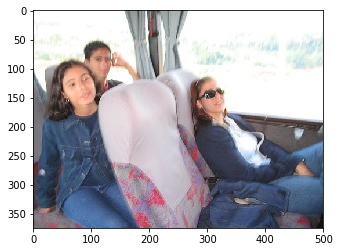

In [10]:
im = imread('../VOCdevkit/images/2010_003355.jpg')
h,w, c = im.shape 
plt.imshow(im)

In [11]:
img = imread('../VOCdevkit/images/000001.jpg')
h, w, c = img.shape
bboxes = np.asarray(labels['000001'])
resized_boxes = np.zeros_like(bboxes)
resized_boxes[:, 0] = bboxes[:, 0] * 224 / w
resized_boxes[:, 2] = bboxes[:, 2] * 224 / w
resized_boxes[:, 1] = bboxes[:, 1] * 224 / h
resized_boxes[:, 3] = bboxes[:, 3] * 224 / h
final_boxes = np.zeros_like(bboxes)
final_boxes[:, 0] = (resized_boxes[:, 0] + resized_boxes[:, 2]) * 0.5
final_boxes[:, 1] = (resized_boxes[:, 1] + resized_boxes[:, 3]) * 0.5
final_boxes[:, 2] = resized_boxes[:, 2] - resized_boxes[:, 0]
final_boxes[:, 3] = resized_boxes[:, 3] - resized_boxes[:, 1]
print(final_boxes)
print(resized_boxes)

[[ 76 136  93  59]
 [114 114 218 218]]
[[ 30 107 123 166]
 [  5   5 223 223]]


In [12]:
final_boxes / 224 

array([[ 0.33928571,  0.60714286,  0.41517857,  0.26339286],
       [ 0.50892857,  0.50892857,  0.97321429,  0.97321429]])

In [17]:
y_train[1]

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 1.        ,  0.0544    ,  0.05813333,  0.04      ,  0.05866667],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,

In [14]:
convt = np.asarray(labels['000001'])
bbox = convt[0]
bbox = y_train[1]

In [15]:
y_train[1]

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 1.        ,  0.272     ,  0.29066667,  0.2       ,  0.29333333],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,

In [32]:
img = imread('../VOCdevkit/images/000001.jpg')
h, w, c = img.shape
print(bbox.shape)
bbox[:,:, 1] = bbox[:, :, 1] * w
bbox[:,:, 3] = bbox[:, :, 3] * w
bbox[:,:, 2] = bbox[:, :, 2] * h
bbox[:,:, 4] = bbox[:, :, 4] * h

xmins = np.expand_dims(bbox[:,:, 1] - bbox[:,:, 3] / 2, -1)
ymins = np.expand_dims(bbox[:,:, 2] - bbox[:,:, 4] / 2, -1)
print(xmins.shape, ymins.shape)

(5, 5, 5)
(5, 5, 1) (5, 5, 1)


In [35]:
np.expand_dims(bbox[:, :, 3],-1).shape

(5, 5, 1)

In [36]:
final_boxes = np.concatenate((xmins, ymins, np.expand_dims(bbox[:, :, 3],-1), np.expand_dims(bbox[:, :, 4], -1)),-1)
final_boxes.shape

(5, 5, 4)

In [40]:
for each_block in final_boxes:
    for each_box in each_block:
        print(each_box)

[ 0.  0.  0.  0.]
[ 0.  0.  0.  0.]
[ 0.  0.  0.  0.]
[ 0.  0.  0.  0.]
[ 0.  0.  0.  0.]
[ 0.  0.  0.  0.]
[ -6.45821952e+11  -3.05680000e+12   1.29333328e+12   6.12086667e+12]
[ 0.  0.  0.  0.]
[ 0.  0.  0.  0.]
[ 0.  0.  0.  0.]
[ 0.  0.  0.  0.]
[ 0.  0.  0.  0.]
[ 0.  0.  0.  0.]
[ 0.  0.  0.  0.]
[ 0.  0.  0.  0.]
[ -6.28962298e+11  -6.97230000e+12   1.25906741e+12   1.39598667e+13]
[ 0.  0.  0.  0.]
[ 0.  0.  0.  0.]
[ -1.73584563e+12  -6.56103333e+12   3.47646750e+12   1.31375667e+13]
[ 0.  0.  0.  0.]
[ 0.  0.  0.  0.]
[ 0.  0.  0.  0.]
[ 0.  0.  0.  0.]
[ 0.  0.  0.  0.]
[ 0.  0.  0.  0.]


In [54]:
bbox[0] * 224 // w, bbox[1] * 224 / h, bbox[2] * 224 / w, bbox[3] * 224 / h 

(30, 107.52, 123.73937677053824, 166.208)

In [33]:
all_boxes = np.asarray(labels['2010_003355'])
all_xmin = np.expand_dims(all_boxes[:, 0] * 224 / w, 1)
all_xmax = np.expand_dims(all_boxes[:, 2] * 224 / w, 1)
all_ymin = np.expand_dims(all_boxes[:, 1] * 224 / h, 1)
all_ymax = np.expand_dims(all_boxes[:, 3] * 224 / h, 1)
transformed_boxes = np.hstack((all_xmin, all_ymin, all_xmax, all_ymax))

In [ ]:
### verify whether the boxes fit in the resized dimensions
for i in range(5):
    plt.imshow(x_train[1])
    plt.gca().add_patch(plt.Rectangle((xmins[i, :, , each_box[1]), each_box[2] - each_box[0], each_box[3] - each_box[1], fill=False, linewidth=2, color='g'))

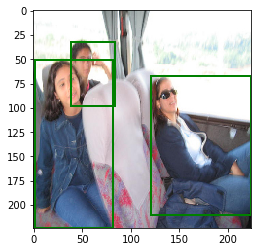

In [35]:
### verify whether the boxes fit in the resized dimensions
for each_box in bbox:
    plt.imshow(x_train[1])
    plt.gca().add_patch(plt.Rectangle((each_box[0], each_box[1]), each_box[2] - each_box[0], each_box[3] - each_box[1], fill=False, linewidth=2, color='g'))

In [32]:
all_boxes = np.expand_dims(np.asarray(labels['2010_003355'])[0], 0)
all_xmin = np.expand_dims(all_boxes[:, 0] * 224 / w, 1)
all_xmax = np.expand_dims(all_boxes[:, 2] * 224 / w, 1)
all_ymin = np.expand_dims(all_boxes[:, 1] * 224 / h, 1)
all_ymax = np.expand_dims(all_boxes[:, 3] * 224 / h, 1)
np.hstack((all_xmin, all_ymin, all_xmax, all_ymax))

array([[ 120.512     ,   67.49866667,  224.        ,  210.26133333]])

In [10]:
def visualize_grid_with_gt(img, y_vector, img_resize, grid_size=(3, 3), is_wh=False):
    
    grid_x, grid_y, preds = y_vector.shape
    real_h, real_w, c = img.shape
    img = resize(img, img_resize, mode='reflect')
    plt.imshow(img)
    ax = plt.gca()
    coords, centers = get_grid_info(img_size=img_resize, grid_size=(grid_size[0], grid_size[1]))
    grid_num = 0
    for each_grid_coords, each_grid_center in zip(coords, centers):
        plt.gca().add_patch(plt.Rectangle((each_grid_coords[0], each_grid_coords[1]), each_grid_coords[2] - each_grid_coords[0] + 1, each_grid_coords[3] - each_grid_coords[1]+1, fill=False, edgecolor='g', linewidth=2))
        plt.plot(each_grid_center[0], each_grid_center[1], marker='o', markersize=5, color='y')
        single_vector = y_vector[grid_num // grid_x , grid_num % grid_y, : ]
        #print(single_vector)
        if  np.sum(single_vector) == 0:
            pass
        elif not is_wh:
            print("in first")
            obj_center = get_center(single_vector[1:])
            plt.plot(obj_center[0],obj_center[1], marker='x', markersize=5, color='b')
        else:
            obj_center = single_vector[1:3] * img_resize[0]
            xmin = (obj_center[0] - (single_vector[3]*224) / 2)
            ymin = (obj_center[1] - (single_vector[4] * 224)/ 2)
            #print(xmin, ymin, single_vector[3]*224, single_vector[4]*224)
            plt.gca().add_patch(plt.Rectangle((xmin, ymin), single_vector[3]*224, single_vector[4]*224, fill=False, edgecolor='y', linewidth=2))
            plt.plot(obj_center[0],obj_center[1], marker='x', markersize=5, color='b')
        grid_num += 1
    plt.show()

In [17]:
y_train[1]

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 1.        ,  0.272     ,  0.29066667,  0.2       ,  0.29333333],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,

In [39]:
img = imread('../VOCdevkit/images/'+'2010_003355.jpg')
h, w, c = img.shape
visualize_grid_with_gt(img=img, grid_size=(5, 5),y_vector=y_train[1], img_resize=(224, 224), is_wh=True)

NameError: name 'visualize_grid_with_gt' is not defined

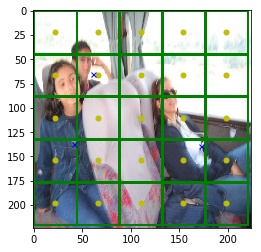

In [40]:
img = imread('../VOCdevkit/images/'+'2010_003355.jpg')
h, w, c = img.shape
visualize_grid_with_gt(img=img, grid_size=(5, 5),y_vector=y_train[1], img_resize=(224, 224), is_wh=True)

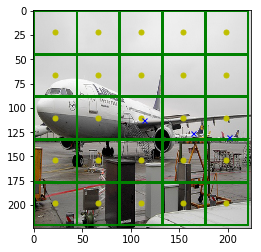

In [14]:
img = imread('../../../VOCdevkit/images/'+'000033.jpg')
visualize_grid_with_gt(img=img, grid_size=(5, 5), y_vector=y_train[3], img_resize=(224, 224))

### testing the method with vanilla vgg16

In [12]:
from keras.models import load_model, model_from_json
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, GlobalAveragePooling2D, Dropout, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import keras.backend as K
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

Using TensorFlow backend.


In [13]:
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [15]:
anchors = 1

In [16]:
x = model.output
x = Conv2D(512, (3, 3), padding='same', activation='relu', name='bbox_1', kernel_initializer='random_uniform')(x)
x = Conv2D(512, (3, 3), padding='same', activation='relu', name='bbox_2', kernel_initializer='random_uniform')(x)
x = Conv2D(512, (3, 3), padding='valid', activation='relu', name='bbox_3', kernel_initializer='random_uniform')(x)
x = Conv2D(5, (1, 1), padding='same', name='grid')(x)
output = Reshape((5, 5, anchors, 4 + 1), name='reshape')(x)

Det_model = Model(inputs=model.input, outputs=output)

In [17]:
for layer in model.layers:
    layer.trainable = False
Det_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [18]:
import tensorflow as tf

In [97]:
def custom_loss(y_true, y_pred):
    y_train_obj = y_true[:, :, :, 0]
    y_pred_obj = y_pred[:, :, :, 0]

    logits = tf.nn.sigmoid(y_pred_obj)
    obj_loss = tf.losses.sigmoid_cross_entropy(y_train_obj, logits)
    
    bbox_true = y_true[:, :, :, 1:]
    bbox_pred = y_pred[:, :, :, 1:]
    
    
    bbox_mse = tf.losses.mean_squared_error(bbox_true, bbox_pred)
    final_loss = obj_loss + bbox_mse
    
    return final_loss

def obj_loss(y_true, y_pred):
    y_train_obj = y_true[:, :, :, 0]
    y_pred_obj = y_pred[:, :, :, 0]
    
    logits = K.sigmoid(y_pred_obj)
    obj_loss = K.binary_crossentropy(y_train_obj, logits)
    
    return obj_loss

def bbox_loss(y_true, y_pred):
    bbox_true = y_true[:, :, :, 1:]
    bbox_pred = y_pred[:, :, :, 1:]
    bbox_mse = tf.losses.mean_squared_error(labels=bbox_true, predictions=bbox_pred)
    
    return bbox_mse

In [11]:
def custom_loss(y_true, y_pred):
    y_train_obj = y_true[:, :, :, 0]
    y_pred_obj = y_pred[:, :, :, 0]
    
    obj_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_train_obj, logits=y_pred_obj)
    
    bbox_true = y_true[:, :, :, 1:]
    bbox_pred = y_pred[:, :, :, 1:]

    bbox_mse = tf.losses.mean_squared_error(labels=bbox_true, predictions=bbox_pred)
    
    final_loss = obj_loss + bbox_mse
    
    return final_loss, obj_loss, bbox_mse

def obj_loss(y_true, y_pred):
    y_train_obj = y_true[:, :, :, 0]
    y_pred_obj = y_pred[:, :, :, 0]
    obj_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_train_obj, logits=y_pred_obj)
    
    return obj_loss

def bbox_loss(y_true, y_pred):
    bbox_true = y_true[:, :, :, 1:]
    bbox_pred = y_pred[:, :, :, 1:]
    bbox_mse = tf.losses.mean_squared_error(labels=bbox_true, predictions=bbox_pred)
    
    return bbox_mse

In [17]:
def get_IOU(y_true, y_pred):
    
    copy_y_pred = tf.cast(y_pred, tf.float32)
    copy_y_true = tf.cast(y_true, tf.float32)
    
    centers_true = copy_y_true[:,:,:, 1:3] 
    whs_true = copy_y_true[:,:,:, 3: ] 
    centers_pred = copy_y_pred[:,:,:, 1:3]
    whs_pred = copy_y_pred[:,:,:, 3: ]

    
    xmin_gt = tf.expand_dims(centers_true[:,:,:, 0] - 0.5 * whs_true[:,:,:, 0], -1)
    ymin_gt = tf.expand_dims(centers_true[:,:,:, 1] - 0.5 * whs_true[:,:,:, 1], -1)
    xmax_gt = tf.expand_dims(whs_true[:,:,:, 0], -1) + xmin_gt
    ymax_gt = tf.expand_dims(whs_true[:,:,:, 1], -1) + ymin_gt
     

    xmin_pred = tf.expand_dims(centers_pred[:,:,:, 0] - 0.5 * whs_pred[:,:,:, 0], -1)
    ymin_pred = tf.expand_dims(centers_pred[:,:,:, 1] - 0.5 * whs_pred[:,:,:, 1], -1)
    xmax_pred = tf.expand_dims(whs_pred[:,:,:, 0], -1) + xmin_pred
    ymax_pred = tf.expand_dims(whs_pred[:,:,:, 1], -1) + ymin_pred


    max_cords_x = tf.maximum(xmin_gt, xmin_pred)
    max_cords_y = tf.maximum(ymin_gt, ymin_pred)
    min_cords_x = tf.minimum(xmax_gt, xmax_pred)
    min_cords_y = tf.minimum(ymax_gt, ymax_pred)

    intersect_area = tf.multiply(tf.add(tf.subtract(min_cords_x, max_cords_x), 1), tf.add(tf.subtract(min_cords_y, max_cords_y),1))


    gt_areas = tf.multiply(tf.add(tf.subtract(xmax_gt, xmin_gt), 1), tf.add(tf.subtract(ymax_gt, ymin_gt), 1))
    pred_areas = tf.multiply(tf.add(tf.subtract(xmax_pred, xmin_pred), 1), tf.add(tf.subtract(ymax_pred, ymin_pred), 1))

    union_area = tf.subtract(tf.add(gt_areas, pred_areas), intersect_area)

    ious = tf.divide(intersect_area, union_area)

    #mean_iou = tf.reduce_mean(iou)

    return ious

In [18]:
def mean_IOU(y_true, y_pred):
    
    copy_y_pred = tf.cast(y_pred, tf.float32)
    copy_y_true = tf.cast(y_true, tf.float32)
    
    centers_true = copy_y_true[:,:,:, 1:3] 
    whs_true = copy_y_true[:,:,:, 3: ] 
    centers_pred = copy_y_pred[:,:,:, 1:3]
    whs_pred = copy_y_pred[:,:,:, 3: ]

    
    xmin_gt = tf.expand_dims(centers_true[:,:,:, 0] - 0.5 * whs_true[:,:,:, 0], -1)
    ymin_gt = tf.expand_dims(centers_true[:,:,:, 1] - 0.5 * whs_true[:,:,:, 1], -1)
    xmax_gt = tf.expand_dims(whs_true[:,:,:, 0], -1) + xmin_gt
    ymax_gt = tf.expand_dims(whs_true[:,:,:, 1], -1) + ymin_gt
     

    xmin_pred = tf.expand_dims(centers_pred[:,:,:, 0] - 0.5 * whs_pred[:,:,:, 0], -1)
    ymin_pred = tf.expand_dims(centers_pred[:,:,:, 1] - 0.5 * whs_pred[:,:,:, 1], -1)
    xmax_pred = tf.expand_dims(whs_pred[:,:,:, 0], -1) + xmin_pred
    ymax_pred = tf.expand_dims(whs_pred[:,:,:, 1], -1) + ymin_pred


    max_cords_x = tf.maximum(xmin_gt, xmin_pred)
    max_cords_y = tf.maximum(ymin_gt, ymin_pred)
    min_cords_x = tf.minimum(xmax_gt, xmax_pred)
    min_cords_y = tf.minimum(ymax_gt, ymax_pred)

    intersect_area = tf.multiply(tf.add(tf.subtract(min_cords_x, max_cords_x), 1), tf.add(tf.subtract(min_cords_y, max_cords_y),1))


    gt_areas = tf.multiply(tf.add(tf.subtract(xmax_gt, xmin_gt), 1), tf.add(tf.subtract(ymax_gt, ymin_gt), 1))
    pred_areas = tf.multiply(tf.add(tf.subtract(xmax_pred, xmin_pred), 1), tf.add(tf.subtract(ymax_pred, ymin_pred), 1))

    union_area = tf.subtract(tf.add(gt_areas, pred_areas), intersect_area)

    ious = tf.divide(intersect_area, union_area)

    mean_iou = tf.reduce_mean(ious)

    return mean_iou

In [ ]:
def obj_accuracy(y_train, y_pred):
    
    obj_cells = tf.expand_dims(y_train[...,0], -1)
    noobj_cells = tf.expand_dims(1 - y_train[...,0], -1)
    
    obj_cells_pred = tf.expand_dims(y_pred[...,0], -1)
    noobj_cells_pred = tf.expand_dims(1 - y_pred[..., 0], -1)
    
    num_objects = tf.reduce_sum(tf.to_float(obj_cells > 0.0))
    num_no_objects = tf.reduce_sum(tf.to_float(noobj_cells > 0.0))
    
    obj_loss = 
    
    

In [158]:
K.eval(get_IOU(np.expand_dims(y_train[0], 0), preds))

array([[[[ -8.03285658e-01],
         [ -9.11334276e-01],
         [ -9.83248532e-01],
         [ -9.92743671e-01],
         [ -8.17814291e-01]],

        [[ -1.31903553e+00],
         [ -8.36130977e-01],
         [ -1.02104449e+00],
         [ -1.00714982e+00],
         [ -1.01430500e+00]],

        [[  2.84782033e-02],
         [ -1.07359111e+00],
         [ -1.02764443e-06],
         [ -1.00174570e+00],
         [ -1.05145848e+00]],

        [[ -1.00304580e+00],
         [ -1.03784418e+00],
         [ -1.03330874e+00],
         [ -1.01599312e+00],
         [ -1.00306869e+00]],

        [[ -9.88228440e-01],
         [ -9.95496273e-01],
         [ -9.98818219e-01],
         [ -1.01992941e+00],
         [ -1.03590846e+00]]]], dtype=float32)

In [19]:
def final_loss(real, preds):
    
    y_train = tf.cast(real, tf.float32)
    y_preds = tf.cast(preds, tf.float32)
    
    gt_boxes = y_train[...,1:]

    gt_conf = y_train[...,0]

    pred_boxes = y_preds[...,1:]

    pred_conf = tf.sigmoid(y_preds[...,0])
    
    obj_cells = tf.expand_dims(y_train[...,0], -1)
    noobj_cells = tf.expand_dims(1 - y_train[...,0], -1)
    
    num_objects = tf.reduce_sum(tf.to_float(obj_cells > 0.0))
    num_no_objects = tf.reduce_sum(tf.to_float(noobj_cells > 0.0))
    
    
    gt_w = gt_boxes[..., 2]
    gt_h = gt_boxes[..., 3]
    
    pred_w = pred_boxes[..., 2]
    pred_h = pred_boxes[..., 3]
    
    gt_centroid_x = gt_boxes[..., 0]
    gt_centroid_y = gt_boxes[..., 1]
    
    
    pred_centroid_x = pred_boxes[..., 0]
    pred_centroid_y = pred_boxes[..., 1]

        
    cent_loss = tf.square(gt_centroid_x - pred_centroid_x) + tf.square(gt_centroid_y - pred_centroid_y)
    
    centroid_loss = obj_cells * tf.expand_dims(cent_loss, 1)
    
    #wh_loss = tf.square(tf.sqrt(gt_w) - tf.sqrt(pred_w)) + tf.square(tf.sqrt(gt_h) - tf.sqrt(pred_h))
    
    wh_loss = tf.square(gt_w - pred_w) + tf.square(gt_h - pred_h)
    
    width_height_loss = obj_cells * tf.expand_dims(wh_loss, 1)
    
    
    coord_loss = tf.reduce_sum(centroid_loss + width_height_loss)
    
    mean_coord_loss = coord_loss / (num_objects + 1e-5)
    
    
    obj_pred_confs = tf.expand_dims(pred_conf, -1) * get_IOU(y_train, y_preds) 
    
    obj_conf_loss = tf.reduce_sum(obj_cells * (tf.expand_dims(gt_conf, -1) - obj_pred_confs))
    
    noobj_conf_loss = tf.reduce_sum(noobj_cells * (tf.expand_dims(gt_conf, -1) - obj_pred_confs))
    
    mean_obj_conf_loss = obj_conf_loss / (num_objects + 1e-5)
    
    mean_noobj_conf_loss = noobj_conf_loss / (num_no_objects + 1e-5)

    
    final_loss = 5 * mean_coord_loss + 5 * mean_obj_conf_loss + 0.5 * mean_noobj_conf_loss
        
    return final_loss

In [ ]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

In [24]:

def exp_loss(y_true, preds):
    
    pred = tf.cast(preds, tf.float32)
    y_true = tf.cast(y_true, tf.float32)


    mask_shape = tf.shape(preds)[:4]

    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(5), [5]), (1, 5, 5, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid =tf.concat([cell_x,cell_y], -1)

    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)


    pred_box_xy = tf.sigmoid(preds[..., 1:3]) + cell_grid

    ### adjust w and h
    pred_box_wh = tf.exp(preds[..., 3:])

    ### adjust confidence
    pred_box_conf = tf.sigmoid(preds[..., 0])


    true_box_xy = y_true[..., 1:3] # relative position to the containing cell

        ### adjust w and h
    true_box_wh = y_true[..., 3:] # number of cells accross, horizontally and vertically

        ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half

    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       


    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    true_box_conf = iou_scores * y_true[..., 0]





    coord_mask = tf.expand_dims(y_true[..., 0], axis=-1) * 1

    mask = tf.equal(y_true[..., 0], 1)
    true_boxes = tf.boolean_mask(y_true, mask)

    true_xy = true_boxes[..., 1:3]

    true_wh = true_boxes[..., 3:]

    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half

    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)

    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    

    intersect_mins  = tf.maximum(pred_mins,  tf.cast(true_mins, tf.float32))


    intersect_maxes = tf.minimum(pred_maxes, tf.cast(true_maxes, tf.float32))
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + tf.cast(true_areas, tf.float32) - tf.cast(intersect_areas, tf.float32)
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)


    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 0]) * 1
    conf_mask = conf_mask + y_true[..., 0] * 5

    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))


    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.

    loss = loss_xy + loss_wh + loss_conf

    nb_true_box = tf.reduce_sum(y_true[..., 0])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))
    
    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    
    ### priting total loss

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    return loss

In [98]:
Det_model.compile(optimizer='rmsprop', loss=custom_loss, metrics=[obj_loss, bbox_loss, IOU])

In [21]:
optim = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-5, decay=0.0)

In [21]:
filepath="multibox-{epoch:02d}-{val_mean_IOU:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_IOU', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [25]:
Det_model.compile(optimizer=optim, loss=exp_loss)

In [26]:
Det_model.fit_generator(training_generator, 26688 // 16, epochs=3 ,validation_data=validation_generator, validation_steps=400//16)

Epoch 1/3
1668/1668 [==============================] - 1125s 675ms/step - loss: 5.1510 - val_loss: 5.0621
Epoch 2/3
1668/1668 [==============================] - 575s 345ms/step - loss: 5.1194 - val_loss: 5.0621
Epoch 3/3
1668/1668 [==============================] - 576s 345ms/step - loss: 5.1194 - val_loss: 5.0621


In [27]:
Det_model.fit_generator(training_generator, 26688 // 16, epochs=5 ,validation_data=validation_generator, validation_steps=400//16)

Epoch 1/5
1668/1668 [==============================] - 571s 342ms/step - loss: 5.1194 - val_loss: 5.0621
Epoch 2/5
1668/1668 [==============================] - 568s 341ms/step - loss: 5.1194 - val_loss: 5.0621
Epoch 3/5
1668/1668 [==============================] - 568s 341ms/step - loss: 5.1194 - val_loss: 5.0621
Epoch 4/5
1668/1668 [==============================] - 568s 340ms/step - loss: 5.1194 - val_loss: 5.0621
Epoch 5/5
1668/1668 [==============================] - 568s 340ms/step - loss: 5.1194 - val_loss: 5.0621


In [31]:
Det_model.fit_generator(training_generator, 26688 // 16, epochs=5 ,validation_data=validation_generator, validation_steps=400//16)

Epoch 1/5
1668/1668 [==============================] - 1553s 931ms/step - loss: 121955.8972 - mean_IOU: 0.5599 - val_loss: 127673.4006 - val_mean_IOU: 0.5600
Epoch 2/5
1668/1668 [==============================] - 904s 542ms/step - loss: 111726.2227 - mean_IOU: 0.5949 - val_loss: 128923.9286 - val_mean_IOU: 0.6231
Epoch 3/5
1668/1668 [==============================] - 1149s 689ms/step - loss: 99017.4025 - mean_IOU: 0.6439 - val_loss: 133172.1641 - val_mean_IOU: 0.6768
Epoch 4/5
1668/1668 [==============================] - 551s 331ms/step - loss: 82473.7782 - mean_IOU: 0.6952 - val_loss: 139867.4750 - val_mean_IOU: 0.7152
Epoch 5/5
1668/1668 [==============================] - 533s 320ms/step - loss: 64571.1897 - mean_IOU: 0.7420 - val_loss: 146847.5013 - val_mean_IOU: 0.7451


In [26]:
load_model?

In [30]:
Det_model = load_model('./multibox-06-0.76.hdf5',compile=False)

In [31]:
Det_model.compile(optimizer=optim, loss=final_loss, metrics=[mean_IOU])

In [48]:
preds = Det_model.predict(np.expand_dims(x_train[1], 0))

In [136]:
preds = Det_model.predict(x_train)

In [20]:
BATCH_SIZE=1

In [73]:
mask_shape = tf.shape(preds)[:4]
print(mask_shape.shape)   
cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(5), [5]), (1, 5, 5, 1, 1)))
cell_y = tf.transpose(cell_x, (0,2,1,3,4))
print(cell_x.shape)
print(cell_y.shape)
cell_grid =tf.concat([cell_x,cell_y], -1)
print(cell_grid.shape)

(4,)
(1, 5, 5, 1, 1)
(1, 5, 5, 1, 1)
(1, 5, 5, 1, 2)


In [75]:
coord_mask = tf.zeros(mask_shape)
conf_mask  = tf.zeros(mask_shape)
print(coord_mask.shape, conf_mask.shape)

(1, 5, 5, 1) (1, 5, 5, 1)


In [76]:
pred_box_xy = tf.sigmoid(preds[..., 1:3]) + cell_grid

### adjust w and h
pred_box_wh = tf.exp(preds[..., 3:])

### adjust confidence
pred_box_conf = tf.sigmoid(preds[..., 0])

In [78]:
pred_box_xy.shape, pred_box_wh.shape, pred_box_conf.shape

(TensorShape([Dimension(1), Dimension(5), Dimension(5), Dimension(1), Dimension(2)]),
 TensorShape([Dimension(1), Dimension(5), Dimension(5), Dimension(1), Dimension(2)]),
 TensorShape([Dimension(1), Dimension(5), Dimension(5), Dimension(1)]))

In [81]:
y_true = y_train[1]

In [82]:
true_box_xy = y_true[..., 1:3] # relative position to the containing cell

    ### adjust w and h
true_box_wh = y_true[..., 3:] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
true_wh_half = true_box_wh / 2.
true_mins    = true_box_xy - true_wh_half
true_maxes   = true_box_xy + true_wh_half
    
pred_wh_half = pred_box_wh / 2.
pred_mins    = pred_box_xy - pred_wh_half
pred_maxes   = pred_box_xy + pred_wh_half       

In [83]:
intersect_mins  = tf.maximum(pred_mins,  true_mins)
intersect_maxes = tf.minimum(pred_maxes, true_maxes)
intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

union_areas = pred_areas + true_areas - intersect_areas
iou_scores  = tf.truediv(intersect_areas, union_areas)

true_box_conf = iou_scores * y_true[..., 0]

In [92]:
mask = y_true[..., 0] == 1 
true_boxes = tf.boolean_mask(y_true, mask)

In [98]:
true_xy = true_boxes[..., 1:3]

true_wh = true_boxes[..., 3:]
    
true_wh_half = true_wh / 2.
true_mins    = true_xy - true_wh_half
true_maxes   = true_xy + true_wh_half

pred_xy = tf.expand_dims(pred_box_xy, 4)
pred_wh = tf.expand_dims(pred_box_wh, 4)

pred_wh_half = pred_wh / 2.
pred_mins    = pred_xy - pred_wh_half
pred_maxes   = pred_xy + pred_wh_half    

intersect_mins  = tf.maximum(pred_mins,  tf.cast(true_mins, tf.float32))


In [110]:
intersect_maxes = tf.minimum(pred_maxes, tf.cast(true_maxes, tf.float32))
intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

true_areas = true_wh[..., 0] * true_wh[..., 1]
pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

union_areas = pred_areas + tf.cast(true_areas, tf.float32) - tf.cast(intersect_areas, tf.float32)
iou_scores  = tf.truediv(intersect_areas, union_areas)

best_ious = tf.reduce_max(iou_scores, axis=4)

In [113]:
conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 0]) * 1

In [118]:
conf_mask = conf_mask + y_true[..., 0] * 5

In [120]:
nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))

In [123]:
loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.

In [128]:
K.eval(loss_conf)

1.135148

In [ ]:
loss = loss_xy + loss_wh + loss_conf

In [130]:
nb_true_box = tf.reduce_sum(y_true[..., 0])
nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

In [145]:
K.eval(exp_loss(y_train, preds))

57.774445

#### excellent indexing my way to get to know bboxes

In [163]:
y_train[3, (y_train[3, :, :,0] == 1)]

array([[  1,   4,  65, 223, 160],
       [  1, 145, 115, 184, 136],
       [  1, 188, 122, 215, 138]])

In [152]:
y_train[3, (y_train[3, :, :, 0] == 0)]

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [157]:
true_objects_mask = (y_train[:, :, :, 0] == 1)
true_objects_mask.shape

(4, 5, 5)

In [162]:
y_train[true_objects_mask]

array([[  1,  86, 132, 137, 224],
       [  1,  41,  25,  86, 224],
       [  1,   0, 165,  12, 197],
       [  1, 203, 165, 224, 188],
       [  1,   4,  65, 223, 160],
       [  1, 145, 115, 184, 136],
       [  1, 188, 122, 215, 138]])

In [ ]:
true_objects_mask = (y_train[:, :, :, 0] == 1)
true_object_inputs = y_train[true_objects_mask]
no_objects_mask = (y_train[:, :, :, 0] == 0)
no_objects_inputs = y_train[no_objects_mask]
object_presence_input = true_object_inputs[]

#### end of excellent bboxes ----------------------------------

In [139]:
y_train[3, :, :,]

array([[[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  1,   4,  65, 223, 160],
        [  1, 145, 115, 184, 136],
        [  1, 188, 122, 215, 138]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]]])

In [117]:
y_train[:, :, :, 0], y_train[:, :, :, 1:]

ValueError: operands could not be broadcast together with shapes (4,5,5) (4,5,5,4) 

In [100]:
y_train[:, :, :, 0] , preds[:, :, :, 0]

(array([[[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0]],
 
        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [1, 0, 0, 0, 1]],
 
        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]]]),
 array([[[ 0.42867598,  0.35086715,  0.36378124,  0.44020969,  0.27385515],
         [ 0.36352858,  0.30997095,  0.27112961,  0.29356119,  0.2511214 ],
         [ 0.39785787,  0.41767052,  0.42296398,  0.45114487,  0.49524561],
         [ 0.49022552,  0.36892691,  0.5450815 ,  0.47621793,  0.47110999],
         [ 0.41960067,  0.21940452,  0.42835286,  0.48870707,  0.33372861]],
 
        [[ 0.32878578,  0.20636937,  0.40615219,  0.37054703,  0.36474374],
         

In [88]:
K.eval(tf.losses.sigmoid_cross_entropy(y_train[:, :, :, 0],tf.nn.sigmoid(preds[:,:,:,0])))

0.90204424

In [101]:
K.eval(tf.losses.sigmoid_cross_entropy(y_train[:, :, :, 0],tf.nn.sigmoid(preds[:,:,:,0])))

0.99500221

In [106]:
K.eval(tf.losses.mean_squared_error(y_train[:, :, :, 1:], preds[:, :, :, 1:]))

1637.3862

In [ ]:
K.eval(tf.losses.sigmoid_cross_entropy(y_train[:, :, :, 0],tf.nn.sigmoid(preds[:,:,:,0])))

In [90]:
K.eval(obj_loss(tf.cast(y_train, tf.float32), preds))

array([[[ 0.53859133,  0.51714879,  0.54043227,  0.5464685 ,  0.64806491],
        [ 0.58427513,  0.56883425,  0.53052199,  0.56055307,  0.56320405],
        [ 0.57744271,  0.55141258,  0.51703477,  0.48698473,  0.55709988],
        [ 0.51439691,  0.50974256,  0.52287447,  0.56566709,  0.62095225],
        [ 0.49376696,  0.56390315,  0.85689807,  0.52101743,  0.5718323 ]],

       [[ 0.50787371,  0.48642069,  0.47709545,  0.60087919,  0.59825581],
        [ 0.41038316,  0.42545384,  0.49284297,  0.53017271,  0.58465898],
        [ 0.47485501,  0.92320013,  0.55151623,  0.58343863,  0.60649961],
        [ 0.60665196,  0.58281565,  0.57652968,  0.59013504,  0.62048614],
        [ 0.66512483,  0.66780126,  0.68053353,  0.6591273 ,  0.65778345]],

       [[ 0.55384219,  0.59769475,  0.62833428,  0.66913176,  0.70161736],
        [ 0.56257105,  0.58055651,  0.62696242,  0.62081492,  0.66759998],
        [ 0.54214835,  0.57442898,  0.54021269,  0.55123687,  0.61313766],
        [ 0.51506382,

In [86]:
K.eval(tf.round(tf.nn.sigmoid(preds[:,:,:,0]))) == np.round(sig_out, 0)

array([[[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]]], dtype=bool)

In [85]:
np.round(sig_out, 0)

array([[[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]]], dtype=float32)

In [49]:
Det_model.compile(optimizer='rmsprop', loss=obj_loss)

In [25]:
len(final_parition['train']), len(final_parition['val'])

(26688, 400)

In [50]:
Det_model.fit_generator(training_generator, 26688 // 4, epochs=3 ,validation_data=validation_generator, validation_steps=400//4)

Epoch 1/3
  37/6672 [..............................] - ETA: 42:00 - loss: -276254.4040

KeyboardInterrupt: 

In [21]:
y_train[:, ].shape

(16, 5, 5)

In [33]:
test = y_train[1]

In [30]:
test[:, :, 1].shape

(5, 5)

In [49]:
test

array([[[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  1,  38,  32,  83,  97],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  1,   1,  50,  81, 223],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  1, 120,  67, 224, 210],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]]])

In [55]:
test[:, :, 0]

array([[0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0]])

In [42]:
test[]

array([[[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  1,  38,  32,  83,  97],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  1,   1,  50,  81, 223],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  1, 120,  67, 224, 210],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]]])

In [58]:
y_pred = np.zeros((16, 5, 5))

In [59]:
y_pred

array([[[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 

In [22]:
y_train[:, :, :, 0]

array([[[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0],
        [1, 0, 0, 1, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 1, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0,

In [25]:
y_train[:, :, :, 1:].shape

(16, 5, 5, 4)

In [57]:
np.argmax(y_train[0, :, :, 0], axis=())

array([0, 0, 2, 0, 0], dtype=int64)

In [60]:
y_train[1, :, :, 0]

array([[0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0]])

#### code snippet for the IOU

In [68]:
xmin_gt, xmin_pred =  y_train[:, :, :, 0], y_pred[:, :, :, 0]
ymin_gt, ymin_pred =  y_train[:, :, :, 1], y_pred[:, :, :, 1]
xmax_gt, xmax_pred =  y_train[:, :, :, 2], y_pred[:, :, :, 2]
ymax_gt, ymax_pred =  y_train[:, :, :, 3], y_pred[:, :, :, 3]


max_cords_x = tf.maximum(xmin_gt, xmin_pred)
max_cords_y = tf.maximum(ymin_gt, ymin_pred)

min_cords_x = tf.minimum(xmax_gt, xmax_pred)
min_cords_y = tf.minimum(ymax_gt, ymax_pred)

intersect_area = tf.multiply(tf.add(tf.subtract(min_cords_x, max_cords_x), 1), tf.add(tf.subtract(min_cords_y, max_cords_y),1))

gt_areas = tf.multiply(tf.add(tf.subtract(xmax_gt, xmin_gt), 1), tf.add(tf.subtract(ymax_gt, ymin_gt), 1))
pred_areas = tf.multiply(tf.add(tf.subtract(xmax_pred, xmin_pred), 1), tf.add(tf.subtract(ymax_pred, ymin_pred), 1))

union_area = tf.subtract(tf.add(gt_areas, pred_areas), intersect_area)

iou = tf.divide(intersect_area / union_area)

In [38]:
def sigmoid(x):
    
    return 1 / (1 + np.exp(-x))

In [71]:
def sigmoid_cross_entropy(true, pred):
    return - np.sum(np.multiply(true, np.log(pred)))
    